<a href="https://colab.research.google.com/github/tawiahnyt/phishing-detection/blob/main/Url_Detector_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack
import pandas as pd
import seaborn as sns
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.6 MB/s eta 0:00:00


In [16]:
df = pd.read_csv('https://huggingface.co/datasets/imanoop7/phishing_url_classification/resolve/main/phishing_dataset.csv')

In [17]:
df.shape

(100000, 2)

In [18]:
df.head()

,text,label
0,http://serviceoffer.gov/login,1
1,http://debitmail.me/profile,1
2,https://www.washingtonpost.com,0
3,http://netflixinvest.edu/dashboard,1
4,https://www.reddit.com,0


In [25]:
df_malicious = df[df.label==1]
df_legitimate = df[df.label==0]


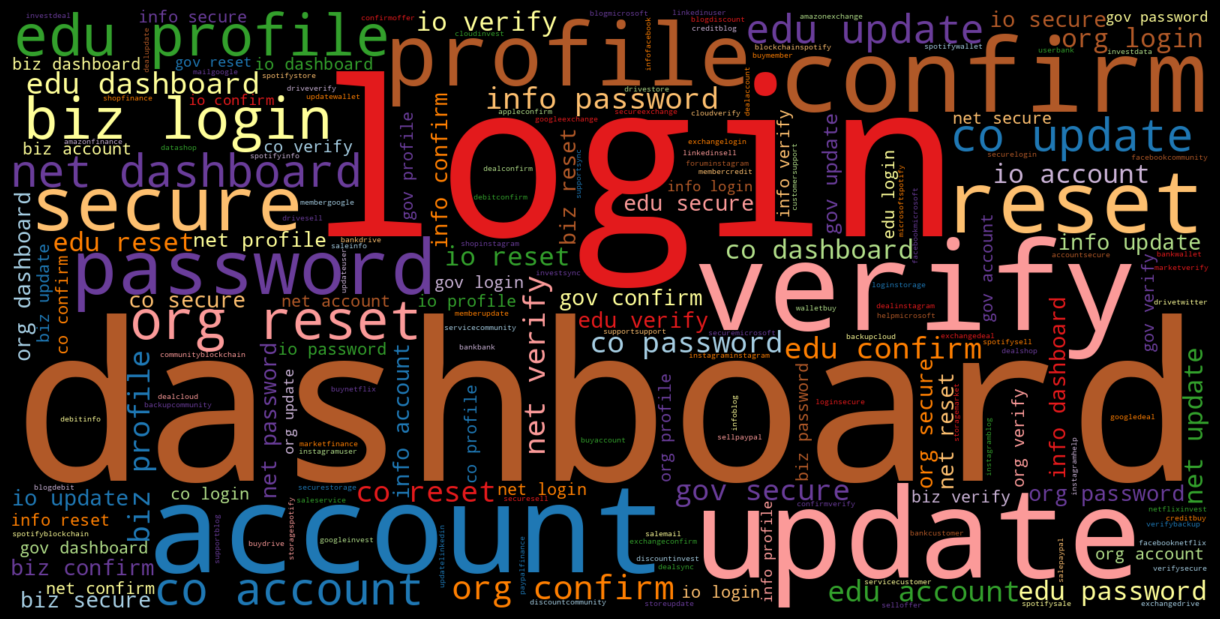

In [29]:
malicious_url = " ".join(i for i in df_malicious.text)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malicious_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

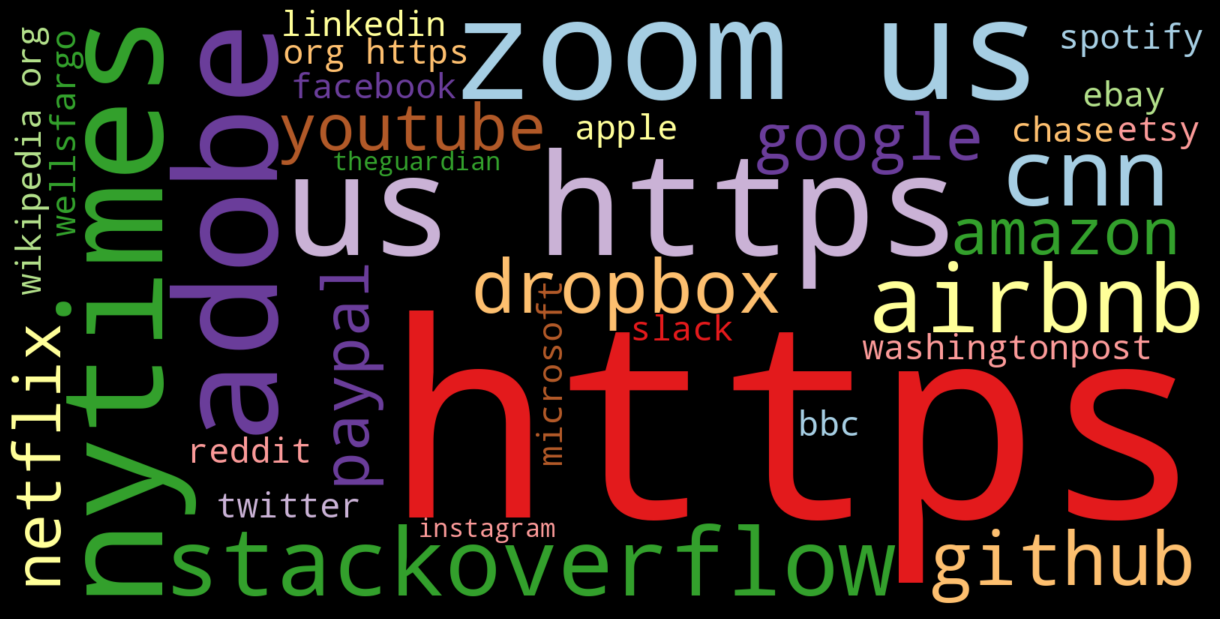

In [30]:
legitimate_url = " ".join(i for i in df_legitimate.text)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(legitimate_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [19]:
# Define your existing extractor
def extract_features(url):
    from urllib.parse import urlparse
    import re

    parsed = urlparse(url)
    return {
        'url_length': len(url),
        'num_dots': url.count('.'),
        'has_https': int(parsed.scheme == 'https'),
        'domain_length': len(parsed.netloc),
        'path_length': len(parsed.path),
        'uses_ip': int(bool(re.match(r'\d+\.\d+\.\d+\.\d+', parsed.netloc))),
        'num_special_chars': sum(1 for c in url if not c.isalnum() and c not in ['.', '/', ':']),
        'has_at': int('@' in url),
        'has_dash': int('-' in url),
    }

In [20]:
# Feature sets
X_struct = pd.DataFrame([extract_features(url) for url in df['text']])
y = df['label']

# TF-IDF vectorizer
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), max_features=500)
X_text = tfidf.fit_transform(df['text'])

In [21]:
# Combine both
from scipy.sparse import csr_matrix
X_combined = hstack([csr_matrix(X_struct.values), X_text])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [37]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt')
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = model.predict(X_val)
print(classification_report(y_val,y_pred,target_names=['legitimate', 'malicious']))

score = accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     10006
   malicious       1.00      1.00      1.00      9994

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

accuracy:   1.000


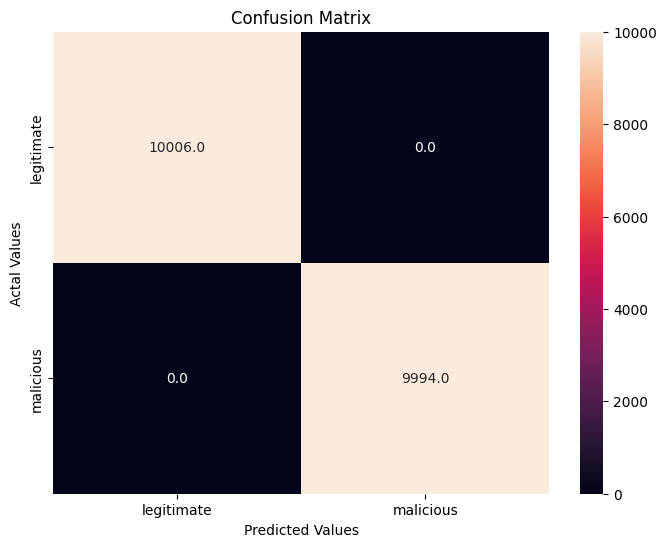

In [39]:
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['legitimate', 'malicious'],
                     columns = ['legitimate', 'malicious'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [53]:
external_urls = [
    "https://paypal.com/login",
    "http://secure-update.bankofamerica.support",
    "https://github.com",
    "http://google.verify-center.login.info",
    "https://university.edu",
    "http://paypal-useraccount.cf/login",
    "https://chat.openai.com",
    "https://site.gctu.edu.gh",
    'titaniumcorporate.co.za','https://en.wikipedia.org/wiki/North_Dakota', 'https://colab.research.google.com', 'https://www.youtube.com/', 'https://dafriedman97.github.io/mlbook/content/introduction.html', 'https://github.com', 'https://site.gctu.edu.gh/'
]

# Extract features
external_struct = pd.DataFrame([extract_features(url) for url in external_urls])
external_text = tfidf.transform(external_urls)
external_combined = hstack([csr_matrix(external_struct.values), external_text])

# Predict
external_probs = model.predict_proba(external_combined)[:, 1]
external_preds = (external_probs > 0.5).astype(int)

# Show results
results = pd.DataFrame({
    'url': external_urls,
    'malicious_probability': external_probs,
    'predicted_label': external_preds
})

print(results)


                                                  url  malicious_probability  \
0                            https://paypal.com/login                   0.35   
1          http://secure-update.bankofamerica.support                   1.00   
2                                  https://github.com                   0.32   
3              http://google.verify-center.login.info                   0.98   
4                              https://university.edu                   0.34   
5                  http://paypal-useraccount.cf/login                   1.00   
6                             https://chat.openai.com                   0.32   
7                            https://site.gctu.edu.gh                   0.34   
8                             titaniumcorporate.co.za                   0.71   
9          https://en.wikipedia.org/wiki/North_Dakota                   0.34   
10                  https://colab.research.google.com                   0.32   
11                           https://www